This kernel presents how to predict mulliken charges using SchNetPack.

In [1]:
!pip install schnetpack

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 1.8MB 16.1MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/4e/28/d3/1748daf79d0a526f1a2de70e9a3abcdb50eb01b45eeec4b786
Successfully built schnetpack


# Mulliken Charges

In [2]:
import numpy as np
import pandas as pd
molecules = pd.read_csv('../input/structures.csv')
molecules = molecules.groupby('molecule_name')
mulliken_charges = pd.read_csv('../input/mulliken_charges.csv')
mulliken_charges = mulliken_charges.groupby('molecule_name')

In [3]:
mulliken_charges.get_group('dsgdb9nsd_000003')

,molecule_name,atom_index,mulliken_charge
9,dsgdb9nsd_000003,0,-0.589706
10,dsgdb9nsd_000003,1,0.294853
11,dsgdb9nsd_000003,2,0.294853


In [4]:
mulliken_charges.get_group('dsgdb9nsd_000003').mulliken_charge.sum()

0.0

In [5]:
pd.read_csv('../input/mulliken_charges.csv').mulliken_charge.describe()

count    1.533537e+06
mean    -2.256222e-10
std      2.254392e-01
min     -7.334500e-01
25%     -1.915330e-01
50%      9.867800e-02
75%      1.273960e-01
max      7.289810e-01
Name: mulliken_charge, dtype: float64

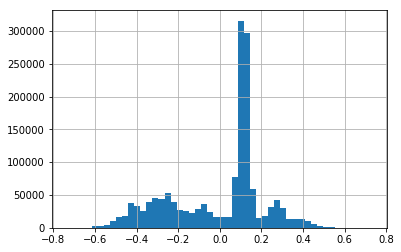

In [6]:
pd.read_csv('../input/mulliken_charges.csv').mulliken_charge.hist(bins=50)

In [7]:
from ase import Atoms
from ase.db import connect

def create_db(db_path, molecule_names):
    with connect(db_path) as db:
        for name in molecule_names:
            mol = molecules.get_group(name)
            atoms = Atoms(symbols=mol.atom.values,
                          positions=[(row.x,row.y,row.z) for row in mol.itertuples()])
            try:
                charges = mulliken_charges.get_group(name).mulliken_charge.values.reshape(-1,1)
                total_charge = 0.0
            except KeyError:
                charges = None
                total_charge = None
            db.write(atoms, name=name,
                     data={'mulliken_charges': charges, 'total_charge': total_charge})

In [8]:
train = pd.read_csv('../input/train.csv')
train_molecule_names = train.molecule_name.unique()

champs_path = 'CHAMPS_train.db'
dataset_size =  len(train_molecule_names) # 12000
dataset_molecule_names = train_molecule_names[:dataset_size]
create_db(db_path=champs_path, molecule_names=dataset_molecule_names)

In [9]:
import schnetpack
database = schnetpack.data.AtomsData(champs_path,
                properties=['mulliken_charges', 'total_charge'])

# SchNet Model

In [10]:
import pandas as pd

import torch
import torch.nn.functional as F
from torch.optim import Adam

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack.datasets import *

device = torch.device("cuda")

In [11]:
# This function comes from the following script:
# https://github.com/atomistic-machine-learning/schnetpack/blob/v0.2.1/src/scripts/schnetpack_qm9.py
def evaluate_dataset(metrics, model, loader, device):
    for metric in metrics:
        metric.reset()

    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)

            for metric in metrics:
                metric.add_batch(batch, result)

    results = [
        metric.aggregate() for metric in metrics
    ]
    return results

In [12]:
from schnetpack.data import Structure

class Mulliken(atm.Atomwise):
    def __init__(self):
        super(Mulliken, self).__init__(return_contributions=True)
        
    def forward(self, inputs):
        result = super().forward(inputs)
        
        atom_mask = inputs[Structure.atom_mask].byte()
        
        yi = inputs['mulliken_charges']
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        inputs['mulliken_true'] = yi
        
        yi = result['yi']
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        result['mulliken_pred'] = yi
        
        return result
        

In [13]:
def schnet_model():
    reps = rep.SchNet(n_interactions=6)
    output = Mulliken()
    model = atm.AtomisticModel(reps, output)
    model = model.to(device)
    return model

In [14]:
def train_model(max_epochs=500):
    # split in train and val
    n_dataset = len(database)
    n_val = n_dataset // 10
    train_data, val_data, test_data = database.create_splits(n_dataset - 2*n_val, n_val)
    train_loader = spk.data.AtomsLoader(train_data, batch_size=128, num_workers=2)
    val_loader = spk.data.AtomsLoader(val_data, batch_size=256, num_workers=2)

    # create model
    model = schnet_model()

    # create trainer
    true_key = 'mulliken_true'
    pred_key = 'mulliken_pred'
    opt = Adam(model.parameters(), lr=1e-4)
    loss = lambda b, p: F.mse_loss(p[pred_key], b[true_key])
    metrics = [
        spk.metrics.MeanAbsoluteError(true_key, pred_key, name='MAE_mulliken'),
        spk.metrics.RootMeanSquaredError(true_key, pred_key, name='RMSE_mulliken'),
    ]
    hooks = [
        spk.train.MaxEpochHook(max_epochs),
        spk.train.CSVHook('log', metrics, every_n_epochs=1),
    ]
    trainer = spk.train.Trainer('output', model, loss,
                            opt, train_loader, val_loader, hooks=hooks)

    # start training
    trainer.train(device)
    
    # evaluation
    model.load_state_dict(torch.load('output/best_model'))
    test_loader = spk.data.AtomsLoader(test_data, batch_size=256, num_workers=2)
    model.eval()

    df = pd.DataFrame()
    df['metric'] = ['MAE_mulliken', 'RMSE_mulliken']
    df['training'] = evaluate_dataset(metrics, model, train_loader, device)
    df['validation'] = evaluate_dataset(metrics, model, val_loader, device)
    df['test'] = evaluate_dataset(metrics, model, test_loader, device)
    display(df)
    
    return test_data

In [15]:
def show_history():
    df = pd.read_csv('log/log.csv')
    display(df.tail())
    max_value = None # df['RMSE_mulliken'].min()*5
    _ = df[['MAE_mulliken','RMSE_mulliken']].plot(ylim=(0,max_value))

In [16]:
def test_prediction(dataset):
    # create model
    model = schnet_model()
    
    # load best parameters
    model.load_state_dict(torch.load('output/best_model'))
    loader = spk.data.AtomsLoader(dataset, batch_size=256, num_workers=2)
    model.eval()
    
    # predict mulliken charges
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)
            targets += batch['mulliken_true'].tolist()
            predictions += result['mulliken_pred'].tolist()
    return targets, predictions

In [17]:
def show_predictions(dataset):
    targets, predictions = test_prediction(dataset)
    df_pred = pd.DataFrame()
    df_pred['Target'] = targets
    df_pred['Prediction'] = predictions
    df_pred.plot.scatter(x='Target', y='Prediction')

# Results

,metric,training,validation,test
0,MAE_mulliken,0.003483,0.00365,0.003674
1,RMSE_mulliken,0.005054,0.00551,0.005447


,Time,Learning rate,Train loss,Validation loss,MAE_mulliken,RMSE_mulliken
195,22314.875348,0.0001,0.014156,0.000032,0.003795,0.005662
196,22420.585965,0.0001,0.014103,0.000032,0.003752,0.005623
197,22526.058580,0.0001,0.014069,0.000031,0.003694,0.005565
198,22631.141318,0.0001,0.014071,0.000030,0.003650,0.005510
199,22736.413962,0.0001,0.014140,0.000032,0.003719,0.005613


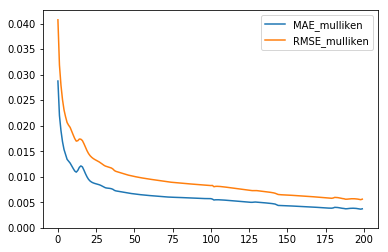

In [18]:
used_test_data = train_model(max_epochs=200)
show_history()

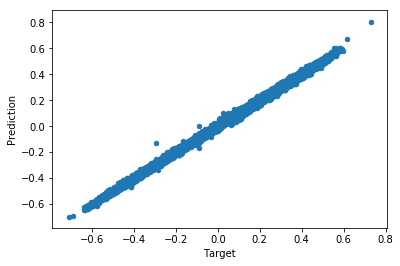

In [19]:
show_predictions(used_test_data)